Start

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

In [2]:
df = pd.read_csv('C:/Users/91635/Desktop/Kuss/TDL/Reviews.csv')
print(df.shape)
df = df.head(1500)
print(df.shape)

(568454, 10)
(1500, 10)


In [3]:
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA

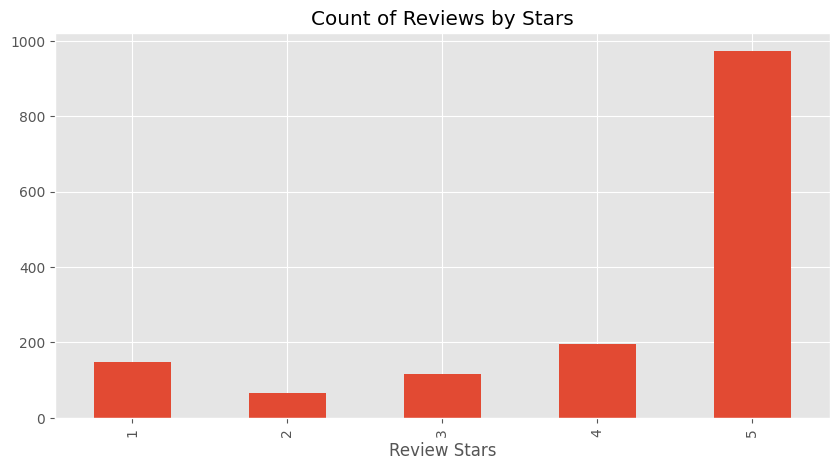

In [18]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [21]:
example = df['Text'][50]

print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [22]:
tokens = nltk.word_tokenize(example, language='english', preserve_line=True)
tokens[:]

['This',
 'oatmeal',
 'is',
 'not',
 'good.',
 'Its',
 'mushy',
 ',',
 'soft',
 ',',
 'I',
 'do',
 "n't",
 'like',
 'it.',
 'Quaker',
 'Oats',
 'is',
 'the',
 'way',
 'to',
 'go',
 '.']

In [24]:
tagged = nltk.pos_tag(tokens)
tagged[:10]
#  'NN' for noun, 'VBZ' for verb, 'RB' for adverb, 'JJ' for adjective , 'DT' for determiner , 'PRP' for personal pronoun

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good.', 'VB'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ'),
 (',', ',')]

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good./VB
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it./JJ
  (PERSON Quaker/NNP Oats/NNP)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Seniment Scoring

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer # used for sentiment analysis
from tqdm.notebook import tqdm # progress bar library used to show progress in loops or tasks

sia = SentimentIntensityAnalyzer()
#The polarity_scores() method of the SentimentIntensityAnalyzer 
#returns a dictionary containing the sentiment scores for the input text.

# The sentiment scores provided by VADER include:

# Positive score: The proportion of text in the input that falls into the positive sentiment category.
# Neutral score: The proportion of text in the input that falls into the neutral sentiment category.
# Negative score: The proportion of text in the input that falls into the negative sentiment category.
# Compound score: A single metric that represents the overall sentiment of the input text, calculated 
# by summing the valence scores of each word in the text, 
# adjusted according to various rules, and then normalized to range between -1 (most negative) and +1 (most positive).

In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1500 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Plot VADER results


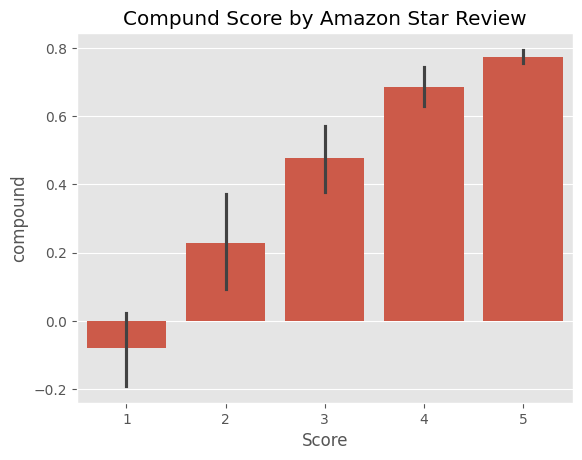

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

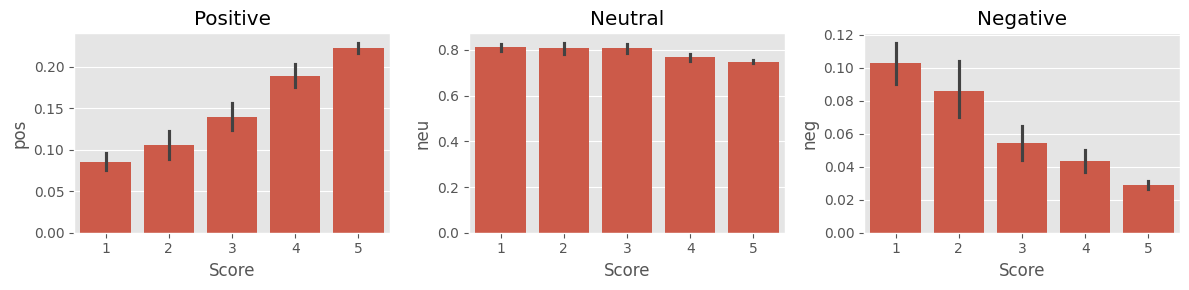

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming vaders is your DataFrame

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plotting positive sentiment
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
axs[0].set_title('Positive')

# Plotting neutral sentiment
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
axs[1].set_title('Neutral')

# Plotting negative sentiment
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()


# Step 3. Roberta Pretrained Model

In [18]:
from transformers import AutoTokenizer #The AutoTokenizer class helps in tokenizing (breaking down) text into smaller units called tokens, which is essential for NLP tasks.
from transformers import AutoModelForSequenceClassification #This line imports the AutoModelForSequenceClassification class from the Transformers library. This class is used for sequence classification tasks, where the goal is to classify a sequence of words or tokens into different categories or labels. The "Auto" part means that it automatically selects the appropriate model based on the task you're working on.
from scipy.special import softmax # This line imports the softmax function from the SciPy library. The softmax function is a mathematical function used in machine learning and statistics, especially in classification problems. It converts a vector of numbers into a probability distribution, making it useful for tasks like multi-class classification, where you want to predict the probabilities of different classes.

In [19]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [20]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [21]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573692}


In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498


In [24]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Compare Scores between models

In [25]:
results_df.columns


Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3. Combine and compare

C:\Users\91635\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


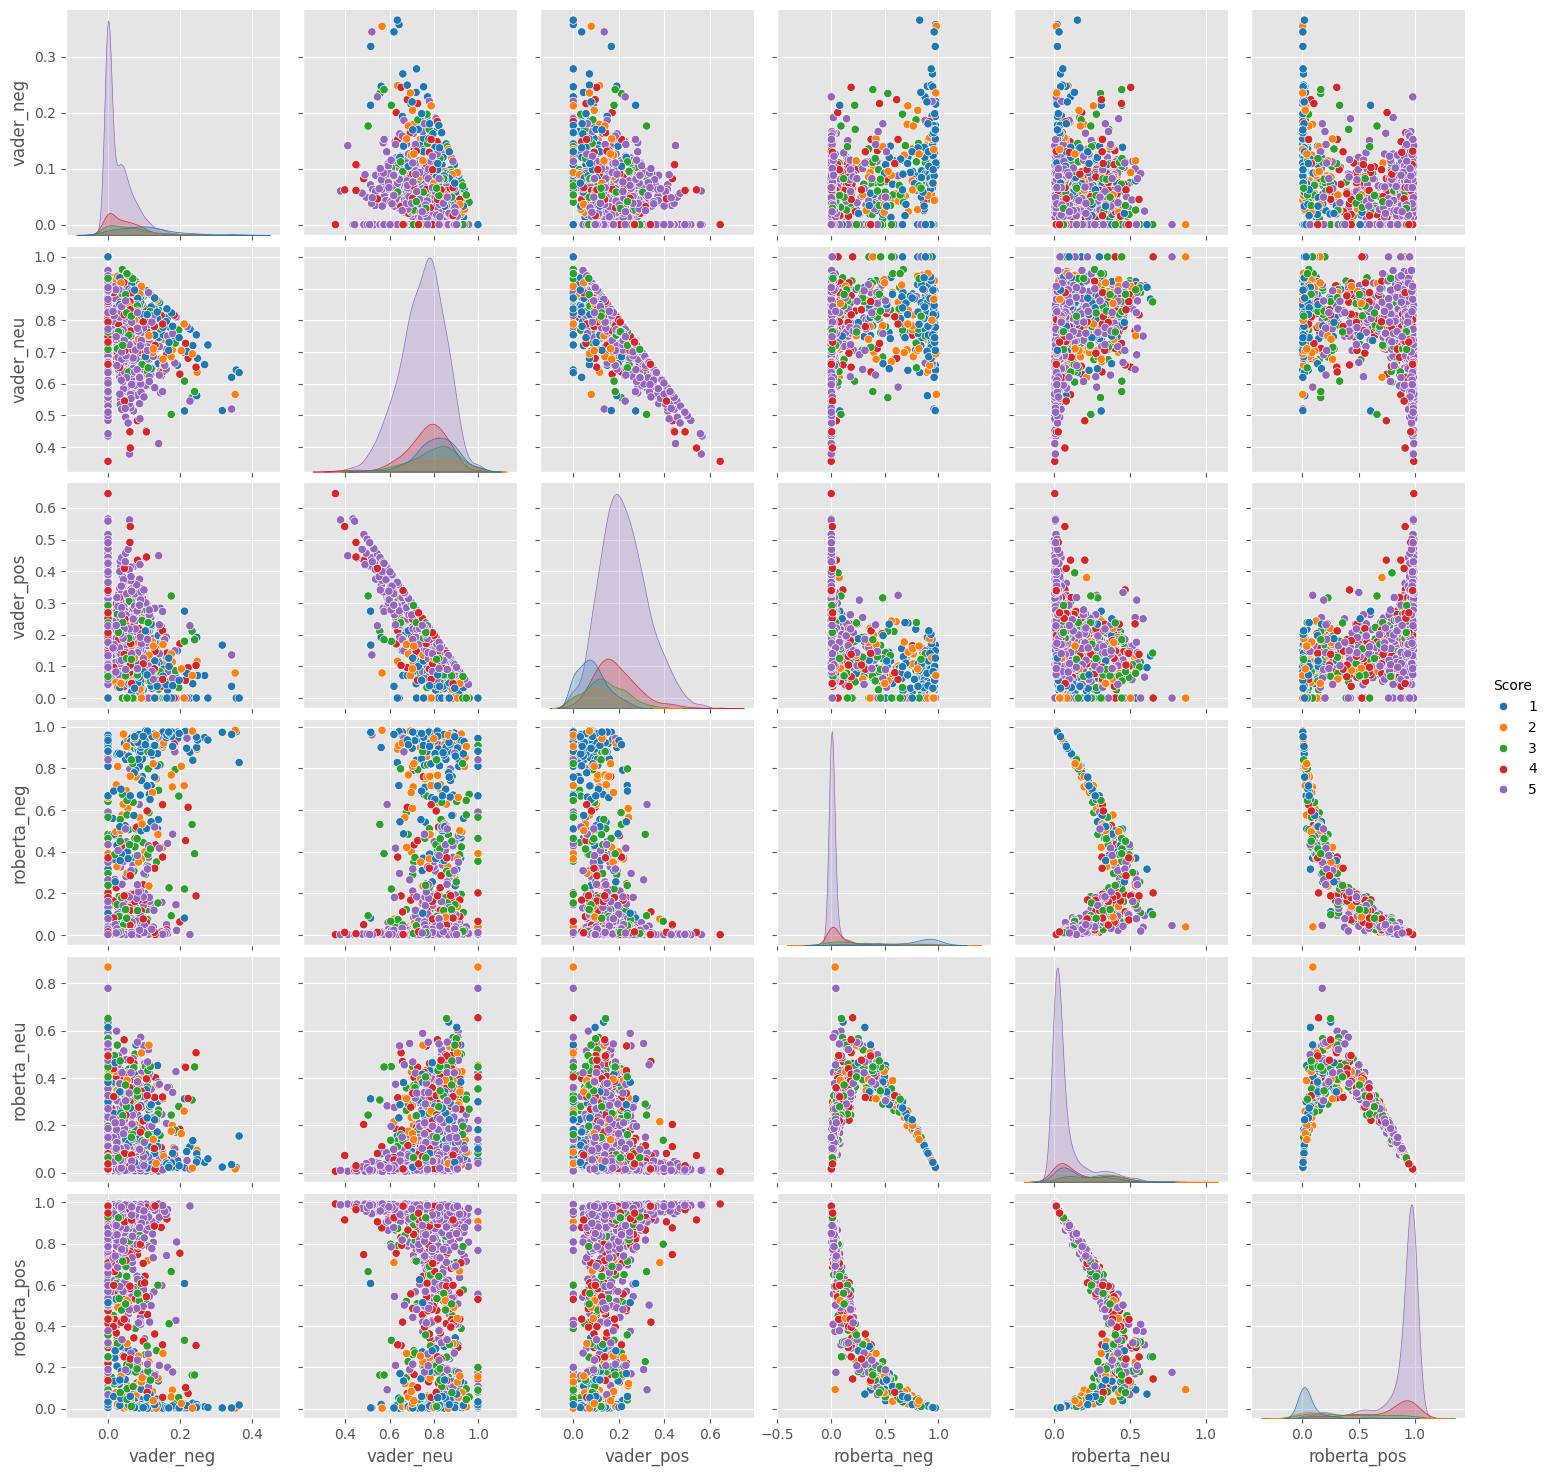

In [26]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:
Positive 1-Star and Negative 5-Star Reviews

In [27]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [28]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [29]:
# nevative sentiment 5-Star view

In [30]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [31]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

#The sentiment analysis tools (RoBERTa and VADER) might not always capture the nuances of sentiment expressed in text accurately, especially in cases of sarcasm or mixed sentiments.
# The context of the review, including specific phrases and tone, can affect the sentiment analysis results.
# Human judgment and context understanding may be necessary to interpret sentiment accurately in some cases.

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline

In [32]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.2.1+cu121 with CUDA 1201 (you have 2.2.1+cpu)
    Python  3.11.8 (you have 3.11.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [33]:
pip install xformers

Note: you may need to restart the kernel to use updated packages.


In [34]:
sent_pipeline('I love sentiment analysis!')


[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [54]:
sent_pipeline('Thanks for making my life miserable')

[{'label': 'NEGATIVE', 'score': 0.8973926305770874}]

In [55]:
sent_pipeline('This top is pretty ugly')

[{'label': 'NEGATIVE', 'score': 0.9998124241828918}]

In [44]:
sent_pipeline('this dress makes itchy')

[{'label': 'NEGATIVE', 'score': 0.8952832221984863}]

In [ ]:
#Overall, the code demonstrates the ease of use of the sentiment analysis pipeline provided by the Transformers library. It showcases how one can quickly
# perform sentiment analysis on text data using pre-trained models without the need for extensive setup or coding

#Finally, the code briefly showcases the ease of using the Transformers library's pipeline for sentiment analysis, which abstracts away the complexity of model loading and inference.